<img src='https://investigaciones.uniandes.edu.co/wp-content/themes/vicerrectoria001/images/logo2.png'>
<h1> 
 Departamento de Ingeniería Industrial<br>
 Modelos Avanzados de Análisis de Datos 1<br>
 MIIA<br>
 </h1>
 <ul>
    <li>Angela Fernanda Romero Fonseca - 201819276</li>
    <li>Carlos Francisco Silva Ortiz - 201920463</li>
    <li>Daniela Carolina Sanabria Guerrero -201116798</li>
    <li>Juan Camilo Florez - 201620135</li>
</ul>

## Análisis de quejas y reclamos:

A continuación se analizará una serie de tiempo en la cual se tiene la información del número de quejas y reclamos recibidas día a día para la línea de negocio ARL desde el año 2018 a la fecha; esta línea de negocio está encargada de atender a todas aquellas personas que cuentan con una póliza en la cual se le cubran todos los gastos en caso de sufrir un accidente laboral.

Analizar esta serie y su comportamiento es de vital importancia para la compañía ya que en la medida que se controle y entienda el comportamientos de las quejas y reclamos se podrán prestar soluciones oportunas y anticipadas a los clientes, lo cual contribuirá en una mejora de en la calidad del servicio y el reconocimiento de la compañía.

De esta manera, se realizará un modelo de análisis de series de tiempo ARIMA para anticipar el número de quejas en un horizonte temporal de un mes desde el 3 de junio hasta el 2 de julio de 2020.

In [28]:
%matplotlib notebook
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import numpy as np
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_squared_error
%matplotlib inline
sns.set()

In [29]:
df = pd.read_csv('datasets\quejas_ARL.csv', sep=';')
df['Quejas'] = np.log(df['Quejas'])
df['Quejas'][np.isneginf(df['Quejas'])] = 0

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
festivos = list()
for date in holidays.CO(years=(2017,2018,2019,2020)).items():
  festivos.append(str(date[0]))

festivos.append('2020-06-29')
festivos.append('2020-07-20')

### Comportamiento de la serie
Una primera exploración gráfica de la serie diaria de quejas relacionadas con la rama de ARL del negocio evidencia que en general, si se presentan, hay entre una y tres quejas por día, y que el nivel de quejas tiende a depender estacionalmente con los días de la semana. 

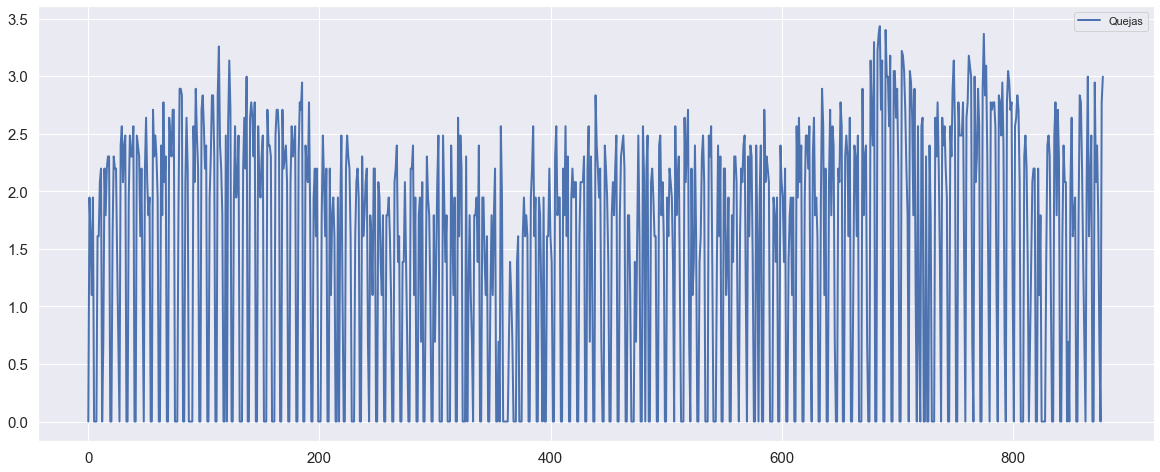

In [31]:
df.plot(figsize=(20,8), linewidth=2, fontsize=15);

### Gráfico de autocorrelación

La función de autocorrelación se comporta de manera decreciente, en línea con lo que mostraría un proceso autoregresivo, en el cual los rezagos anteriores afectan cada observación en t de manera cada vez menor a medida de que el rezago es más lejano. A su vez, se evidencia un comportamiento cíclico de la función, lo cual de momento apoya la hipótesis de que existe una relación entre los días de la semana y el número de quejas.

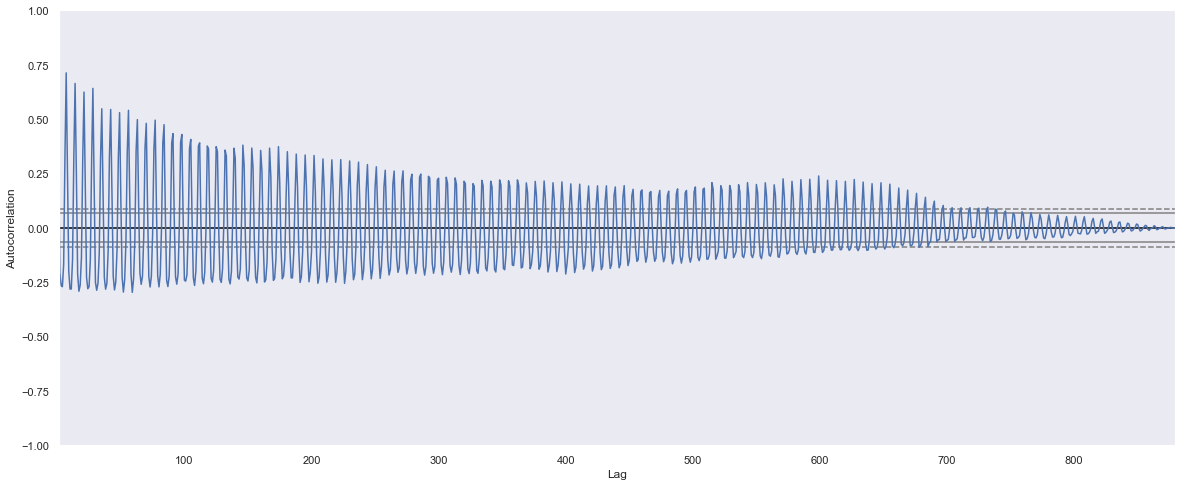

In [32]:
plt.figure(figsize=(20,8))
pd.plotting.autocorrelation_plot(df['Quejas']);

### Test de Dickey Fuller (Serie sin diferenciar)
En primer lugar, es pertinente determinar si la serie a trabajar es estacionaria, es decir, si sus propiedades estadísticas permanecen constantes a través del tiempo. Este es un supuesto clave para que el proceso se pueda modelar y predecir a través de modelos ARIMA. Por lo tanto, se usará la prueba estadística de Dickey-Fuller, cuya hipótesis nula establece que la serie tiene raíz unitaria, y por lo tanto no es estacionaria. 
Así pues, en este caso, se rechaza la hipótesis nula a un nivel de significancia del 5%, lo cual indica que existe evidencia estadística que sugiere que la serie a utilizar sí cumple con el supuesto de estacionariedad.

In [33]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Quejas'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.402515
p-value: 0.010873
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


### Serie diferenciada
A pesar del resultado anterior, a menudo es conveniente diferenciar la serie para mejorar el desempeño predictivo de los modelos. Se observa que la serie con primeras diferencias tiene probablemente media en cero y varianza constante. 

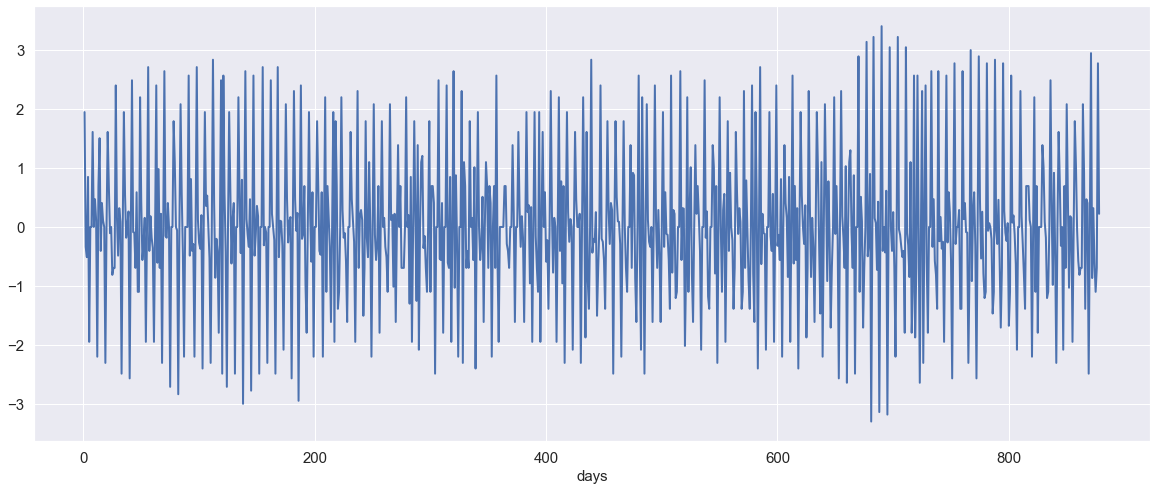

In [34]:
df['Quejas'].diff().plot(figsize=(20,8), linewidth=2, fontsize=15)
plt.xlabel('days', fontsize=15);

### Análisis de tendencia (rolling)
En la gráfica se evidencia una tendencia decreciente en el promedio móvil en las quejas de los dos primeros años. Sin embargo, es evidente que el aumento de las quejas en el tercer año se ve influenciado por la adquisición de una cuenta con aproximadamente 3.000.000 de asegurados. Desde este año se incrementan las quejas considerablemente y la tendencia de las quejas es creciente.

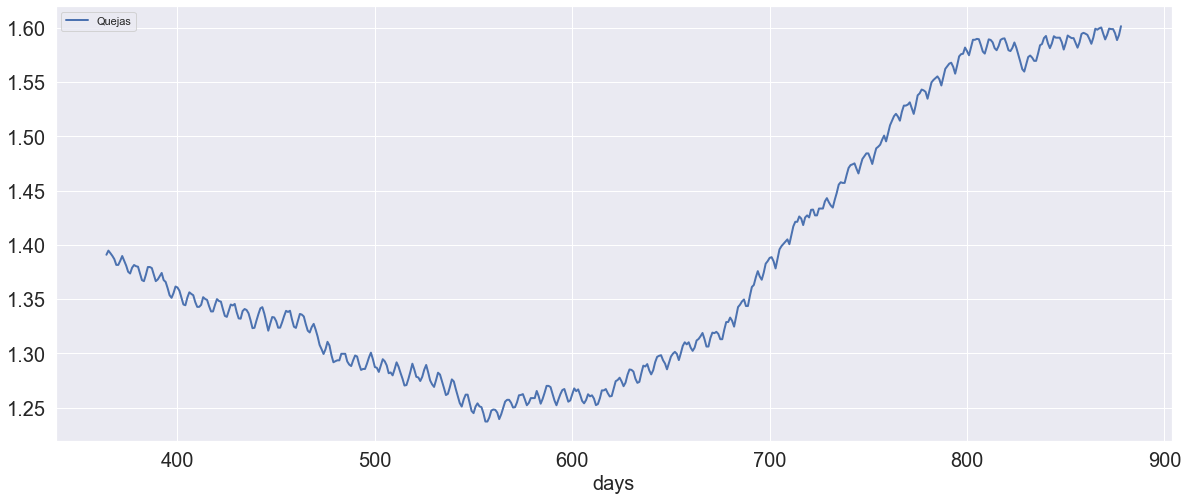

In [35]:
df.rolling(365).mean().plot(figsize=(20,8), linewidth=2, fontsize=20)
plt.xlabel('days', fontsize=20);

### Test de Dickey Fuller (Serie diferenciada)
Haciendo nuevamente la prueba pero esta vez con la serie diferenciada se que nuevamente se rechaza la hipótesis nula por lo cual existe evidencia estadística suficiente para afirmar que esta serie es estacionaria.

In [26]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Quejas'].diff().iloc[1:,])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.754439
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


### Analisis de autocorrelación y auto correlación parcial
La gráfica de autocorrelación parece indicar que esta cae después del séptimo elemento y sigue decreciendo con respecto al tiempo. Por lo tanto, aparenta tener un comportamiento auto regresivo de orden 7.

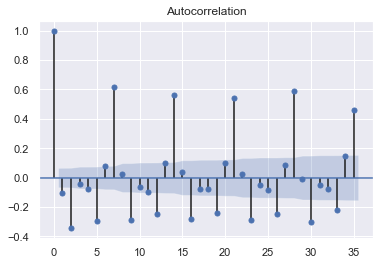

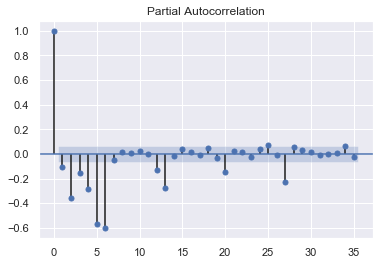

In [27]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(df['Quejas'].diff().iloc[1:,], lags=35);
sm.graphics.tsa.plot_pacf(df['Quejas'].diff().iloc[1:,], lags=35);

# Construcción del modelo

### Construcción del modelo

Con el ánimo de encontrar los parametros óptimos del modelo ARIMA se procede a encontrar la combinación de estos que genere el menor error posible

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")

X = df['Quejas'].values
size = int(len(X) * 0.9)
mse = list()

for p in range(15):
    for q in range(15):
        for d in range(3):
            try:
              if (q>=p):
                mse.append([p,d,q,99999])
                print([p,d,q,99999])
              else: 
                train, test = X[0:size], X[size:len(X)]
                history = [x for x in train]
                predictions = list()
                for t in range(len(test)):
                    model = ARIMA(history, order=(p,d,q))
                    model_fit = model.fit(disp=0)
                    output = model_fit.forecast()
                    yhat = output[0]
                    predictions.append(yhat)
                    obs = test[t]
                    history.append(obs)
                mse.append([p,d,q,mean_squared_error(test, predictions) ** 0.5])
                print([p,d,q,mean_squared_error(test, predictions) ** 0.5])
            except:
                mse.append([p,d,q,99999])
                print([p,d,q,99999])

[0, 0, 0, 99999]
[0, 1, 0, 99999]
[0, 2, 0, 99999]
[0, 0, 1, 99999]
[0, 1, 1, 99999]
[0, 2, 1, 99999]
[0, 0, 2, 99999]
[0, 1, 2, 99999]
[0, 2, 2, 99999]
[0, 0, 3, 99999]
[0, 1, 3, 99999]
[0, 2, 3, 99999]
[0, 0, 4, 99999]
[0, 1, 4, 99999]
[0, 2, 4, 99999]
[0, 0, 5, 99999]
[0, 1, 5, 99999]
[0, 2, 5, 99999]
[0, 0, 6, 99999]
[0, 1, 6, 99999]
[0, 2, 6, 99999]
[0, 0, 7, 99999]
[0, 1, 7, 99999]
[0, 2, 7, 99999]
[0, 0, 8, 99999]
[0, 1, 8, 99999]
[0, 2, 8, 99999]
[0, 0, 9, 99999]
[0, 1, 9, 99999]
[0, 2, 9, 99999]
[0, 0, 10, 99999]
[0, 1, 10, 99999]
[0, 2, 10, 99999]
[0, 0, 11, 99999]
[0, 1, 11, 99999]
[0, 2, 11, 99999]
[0, 0, 12, 99999]
[0, 1, 12, 99999]
[0, 2, 12, 99999]
[0, 0, 13, 99999]
[0, 1, 13, 99999]
[0, 2, 13, 99999]
[0, 0, 14, 99999]
[0, 1, 14, 99999]
[0, 2, 14, 99999]
[1, 0, 0, 1.0128307665685923]
[1, 1, 0, 1.2099006070842733]
[1, 2, 0, 1.606391345023592]
[1, 0, 1, 99999]
[1, 1, 1, 99999]
[1, 2, 1, 99999]
[1, 0, 2, 99999]
[1, 1, 2, 99999]
[1, 2, 2, 99999]
[1, 0, 3, 99999]
[1, 1, 3, 99

In [ ]:
mse = pd.DataFrame(mse)
mse.columns = ['p','d','q','mse']
mse[mse.iloc[:,3]==min(mse.iloc[:,3])]

# Prophet
Haciendo uso del paquete de Prophet, se construyó un modelo que permitiera pronosticar el comportamiento que tendrían el número de quejas y reclamos en los próximos 30 días, como resultado se obtiene el intervalo en el cual se movería la serie tal y como se muestra a continuación, es importante tener en cuenta que dentro del modelo se incluyeron los días feriados para que se tuvieran en cuenta al momento de generar el pronóstico, así mismo es importante tener en cuenta que se hizo una transformación de la serie calculando su logaritmo dada la alta volatilidad de la misma:

In [109]:
import os
os.environ["NUMEXPR_MAX_THREADS"]="16"

df.columns =['ds','y']
df['ds'] = pd.to_datetime(df['ds'],format='%d/%m/%Y')
feriados = pd.DataFrame({
  'holiday': 'colombia',
  'ds': pd.to_datetime(festivos),
  'lower_window': 0,
  'upper_window': 1,
})

feriados.tail(10)
m = Prophet(holidays = feriados,daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False,interval_width=0.90, changepoint_prior_scale=0.01)
m.fit(df);

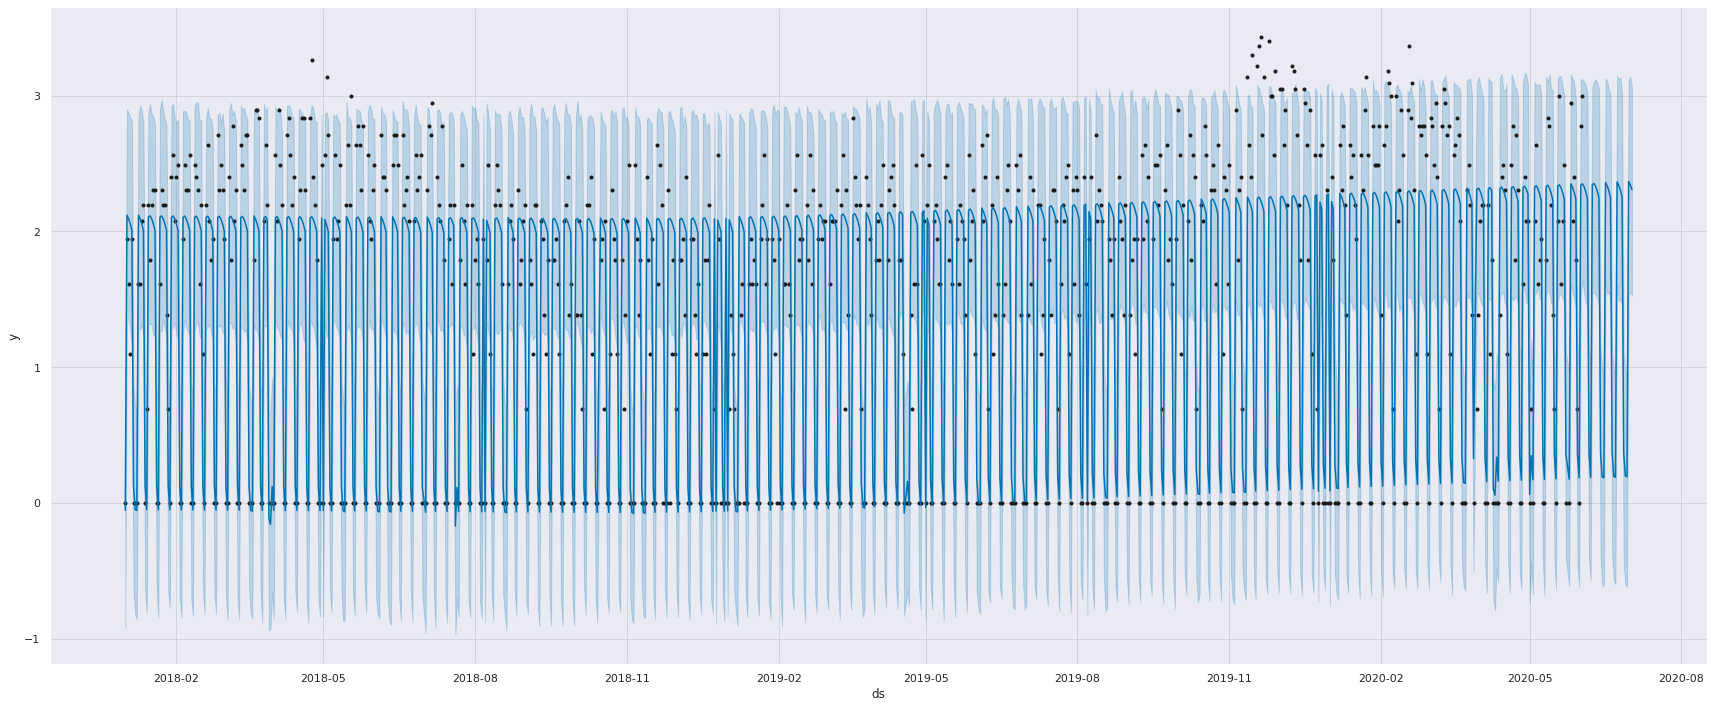

In [110]:
future = m.make_future_dataframe(periods= 30, freq='D')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)
m.plot(forecast,figsize=(24,10));

### Análisis de los componentes
- Analizando el componente de la tendencia, se encuentra que desde finales de 2019 e inicios de 2020 se tiene una tendencia creciente la cual está dada principalmente por la adquisición de un nuevo negocio de ARL la cual trajo consigo cerca de 3.000.000 de nuevos clientes dentro de la compañía, por lo cual es natural encontrar este comportamiento para esta época ya que en la medida que incrementa el volumen de clientes, el volumen de quejas y reclamos aumenta en la misma medida
- En cuanto al componente diario, se tiene que los días sábados y domingos se recibe un volumen inferior de quejas y reclamos con respecto a los demás días de la semana, lo cual se debe a que en su mayoría los clientes tratan de comunicarse en horarios de oficina para radicar este tipo de peticiones, es interesante resaltar que en los días lunes y martes, se resalta que se recibe un volumen mayor de quejas y reclamos con respecto a los días miércoles, jueves y viernes.
- Finalmente, en cuanto al componente de los días feriados, se encuentra que en estos días se deberían recibir menos quejas y reclamos que lo que sucede de lunes a viernes, lo cual es habitual teniendo en cuenta que se trata de días no laborales

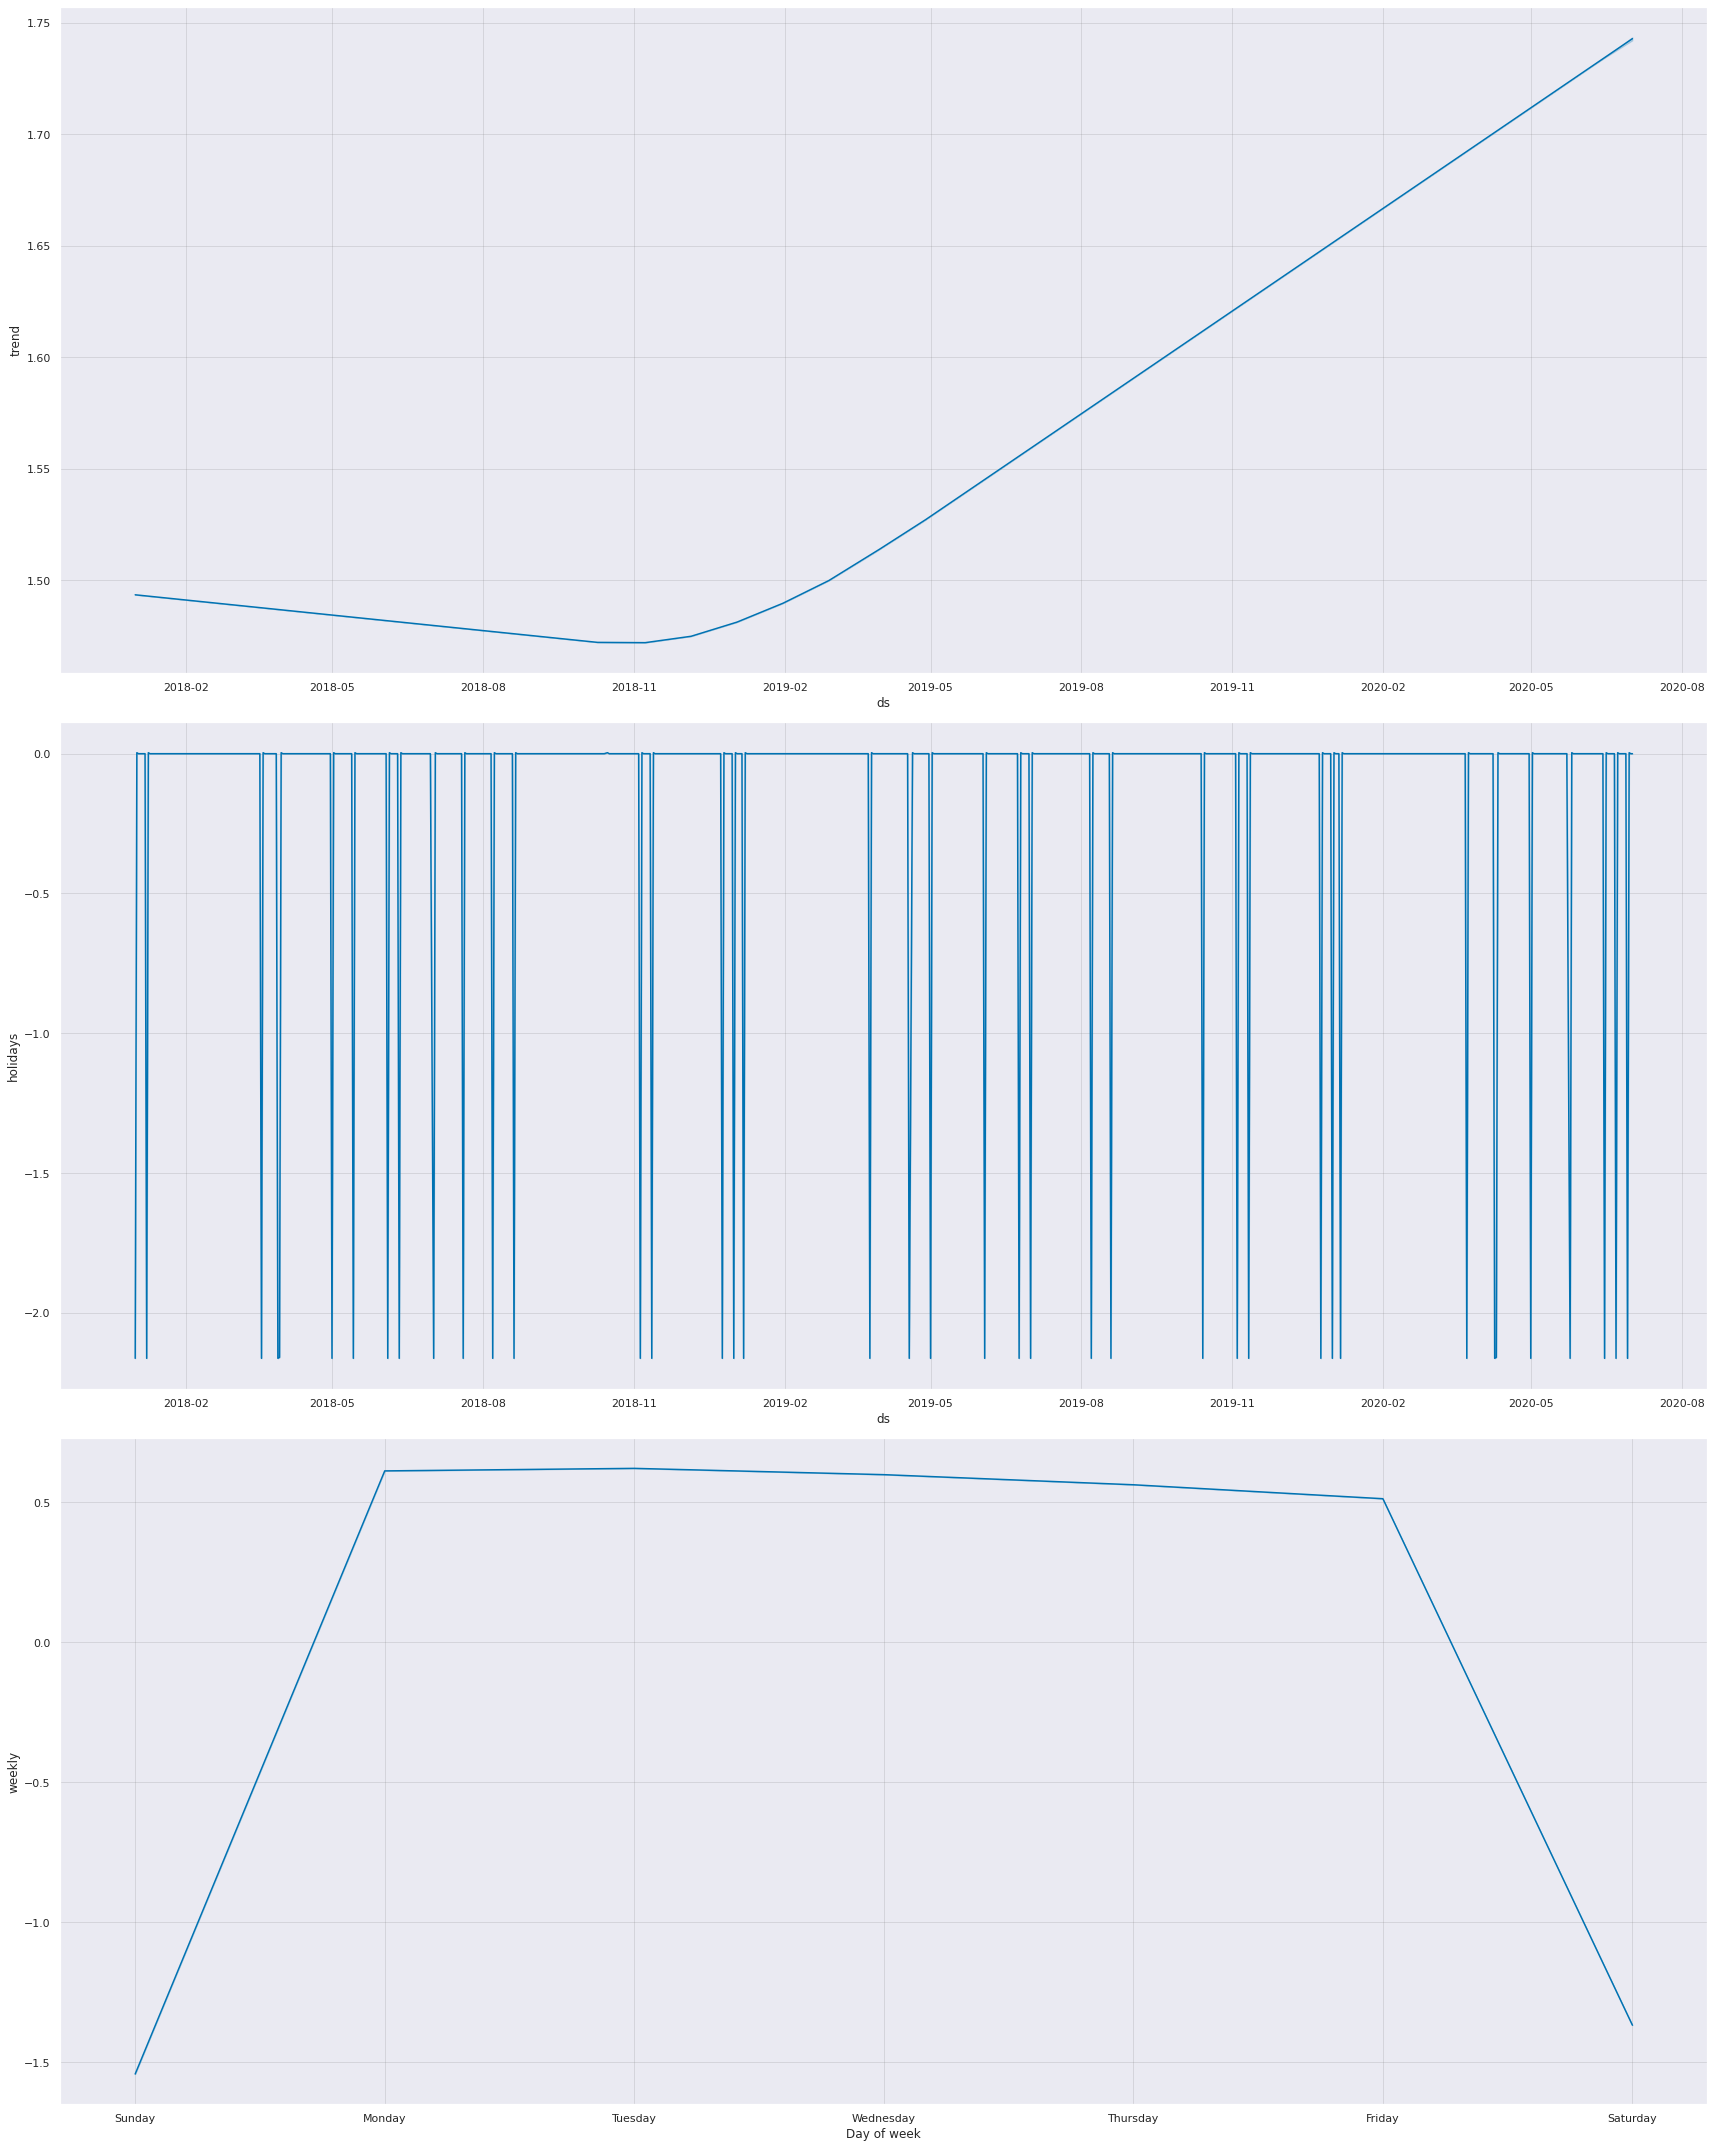

In [111]:
m.plot_components(forecast, figsize=(24,30));

# Análisis Rolling Forecast con Prophet
Luego de construir un Rolling Forecast, tenemos que el resultado es bastante positivo ya que el MSE calculado a partir de este es del 0.52, siendo de esta manera un mejor resultado frente al que se obtuvo con el mejor ARIMA previamente construido

In [112]:
size = int(len(df['y']) * 0.9)
train = df[:size]
test = df[size:]
predictions = np.zeros(len(test))
for t in range(len(test)):
    m = Prophet(holidays = feriados,daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False,interval_width=0.90, changepoint_prior_scale=0.01)
    m.fit(train)
    future=pd.DataFrame(df['ds'][:(size+t+1)])
    forecast = m.predict(future)
    forecast = forecast[['ds', 'yhat']].tail(1)
    forecast.columns = ['ds','y']
    train = train.append(forecast)
    predictions[t] = forecast[['y']].values
    mse = mean_squared_error(test['y'].values, predictions) ** 0.5
print('MSE: %.2f' % mse)

MSE: 0.52


### Validación comportamiento de los errores

Finalmente, con el ánimo de validar si se cuenta con normalidad en los errores y verificar que los modelos previamente aplicados sean consistentes se aplicó un test para verificar que estos cumplan con este tipo de distribución, frente a ello se encontró que con un nivel de confianza del 95% no se tiene evidencia estadística suficiente para rechazar Ho, por lo cual se puede mencionar que los errores siguen una distribución normal

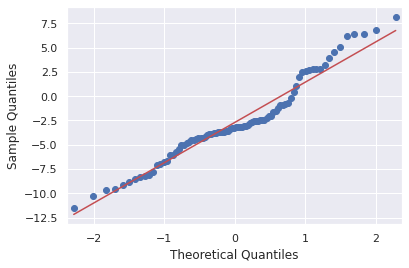

In [113]:
from matplotlib import pyplot
from statsmodels.graphics.gofplots import qqplot
qqplot(error, line='s')
pyplot.show();

In [114]:
from scipy.stats import normaltest
stat, p = normaltest(error)
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)') 

Statistics=4.559, p=0.102
Sample looks Gaussian (fail to reject H0)


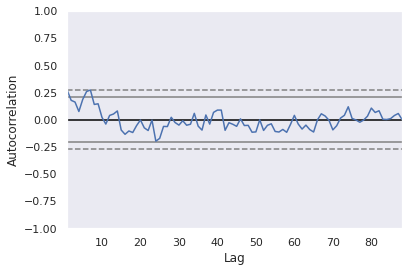

In [115]:
pd.plotting.autocorrelation_plot(error);